# Regression discontinuity design (RDD) on COVID-19 events in Quebec
by Martin Dionne

I've worked with Michael Chan on this project but we decided to summit our own versions made with our respective code.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
#https://resources-covid19canada.hub.arcgis.com/datasets/provincial-daily-totals
df = pd.read_csv('https://opendata.arcgis.com/datasets/3afa9ce11b8842cb889714611e6f3076_0.csv')

df = df.loc[df.Province == 'QUEBEC'].reset_index(drop=True)
df.SummaryDate = pd.to_datetime(df.SummaryDate, format='%Y-%m-%d')
df.SummaryDate = pd.to_datetime(df.SummaryDate.dt.strftime('%Y-%m-%d'))
df

,OBJECTID,Province,Abbreviation,DailyTotals,SummaryDate,TotalCases,TotalRecovered,DailyRecovered,TotalDeaths,DailyDeaths,TotalTested,DailyTested,TotalActive,DailyActive,TotalHospitalized,DailyHospitalized,TotalICU,DailyICU,TotalVaccinated,DailyVaccinated
0,14,QUEBEC,QC,0,2020-01-25,0,0,0,0,0,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,20,QUEBEC,QC,0,2020-01-26,0,0,0,0,0,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,34,QUEBEC,QC,0,2020-01-27,0,0,0,0,0,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,47,QUEBEC,QC,0,2020-01-28,0,0,0,0,0,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,63,QUEBEC,QC,0,2020-01-29,0,0,0,0,0,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,5872,QUEBEC,QC,1624,2021-01-21,248860,221327,1735,9273,65,5533972,32845,18253,-178.0,1453.0,-14.0,216.0,0.0,186210.0,11950.0
363,5902,QUEBEC,QC,1631,2021-01-22,250491,223367,2040,9361,88,5569016,35044,17757,-496.0,1426.0,-27.0,212.0,-4.0,200627.0,14417.0
364,5917,QUEBEC,QC,1685,2021-01-23,252176,225245,1878,9437,76,5612941,43925,17488,-269.0,1383.0,-43.0,216.0,4.0,210252.0,9625.0
365,5932,QUEBEC,QC,1457,2021-01-24,253633,227215,1970,9478,41,5646660,33719,16935,-553.0,1327.0,-56.0,219.0,3.0,218755.0,8503.0


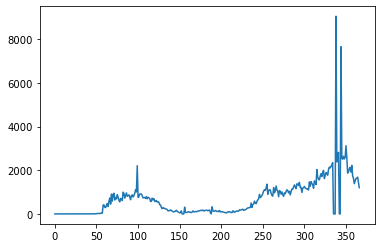

In [3]:
# some datapoints need to be cleaned 
df.DailyTotals.plot()

In [4]:
# clean up dates without data around 2020-12-25, 2021-01-01 and 2021-08-31
feature_list = ['DailyTotals', 'DailyRecovered', 'DailyDeaths']

for f in feature_list:

    avg_dec25 = df[f][338] / 4
    df[f][335] = avg_dec25
    df[f][336] = avg_dec25
    df[f][337] = avg_dec25
    df[f][338] = avg_dec25

    avg_jan1 = df[f][344] / 3
    df[f][342] = avg_jan1
    df[f][343] = avg_jan1
    df[f][344] = avg_jan1

    avg_jul31 = ( df[f][187] + df[f][188] + df[f][189] )/ 3
    df[f][187] = avg_jul31
    df[f][188] = avg_jul31
    df[f][189] = avg_jul31


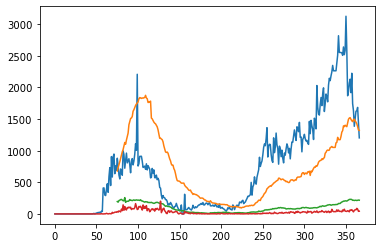

In [5]:
df.DailyTotals.plot()
df.TotalHospitalized.plot()
df.TotalICU.plot()
df.DailyDeaths.plot()

In [6]:
def subset_rdd(df, date, drange=28, lag=0):
    """
    Function to subset a dataframe base on a date and a range
    the overall range is [date - drange, date + drange]
    the lag is used to indroduce a buffer after the selected date
    """
    # event date definition
    event = pd.to_datetime(date) + pd.DateOffset(days=lag)

    # date range selection
    begin, end = (event - pd.DateOffset(days=drange)), (event + pd.DateOffset(days=drange))

    # subset for selected date range
    targets = ['SummaryDate', 'DailyTotals', 'DailyHospitalized','TotalHospitalized', 'TotalICU', 'DailyICU', 'DailyDeaths', 'DailyTested']
    sub = df.loc[(df.SummaryDate >= begin) & (df.SummaryDate <= end)][targets].reset_index(drop=True)

    # reset dates to days
    sub['x'] = sub.index - drange

    # add cutoff variable
    sub['cutoff'] = sub.SummaryDate.apply(lambda x: 1 if (x >= event) else 0)

    # rename columns
    sub = sub.rename(columns={"SummaryDate": "Date", "DailyTotals": "DailyCases"})

    # duplicate cutoff value
    line = sub.loc[sub['x']==0]
    line.cutoff = 0
    sub = sub.append(line)
    sub = sub.sort_values(by=['x', 'cutoff']).reset_index(drop=True)

    return sub

In [7]:
def plot_rdd(sub, feature='DailyCases', deg1=2, deg2=2):
    
    """
    Function to plot a RDD model 
    the input dataframe must to include one or more feature, 
    a Day column and a cutoff column
    deg is the polymonial degree (before and after the cutoff)
    the function will generate a plot and return the model 
    """

    x = sm.add_constant(sub.x)
    x['const_c'] = 1 * sub.cutoff
    if deg1 == 2: x['x2'] = x['x'] ** 2
    x['x_c'] = x['x'] * sub.cutoff
    if deg2 == 2: x['x2_c'] = x['x'] ** 2 * sub.cutoff
    y = sub[feature]
    est = sm.OLS(y,x).fit()
    sub['predictions'] = est.fittedvalues
    
    # get date for title
    date = sub.Date.loc[sub.x == 0].iloc[0].strftime('%Y-%m-%d')

    fig, ax = plt.subplots(figsize=(12,7))
    ax.scatter(x=sub.x, y=sub[feature], color="b")
    ax.axvline(x=0, ls='--', color='grey')
    sub.plot(x='x', y='predictions', ax=ax, color="r")
    #ax.plot(Day, sub.predictions, color="r")
    ax.set_ylabel(feature)
    ax.set_xlabel('Day')
    ax.grid(color='b', ls = '-.', lw = 0.25)
    ax.set_title('COVID-19 Regression Discontinuity on ' + date)

    return est

# General considerations and hypothesis

## Lag between COVID-19 measures and their effect

The average incubation period for COVID-19 is 4 to 5 days according to the CDC (source: https://www.cdc.gov/coronavirus/2019-ncov/hcp/clinical-guidance-management-patients.html) Therefore, a disregarding the first 4-5 days after a measure has been implemented would be logical to determine the impact on the number of new cases.

Similarly, the average time to hospitalization (~7 days) and the average time to death (~14 days) would be suited to measure the impact on those variables. Although, those large lag would allow more variabilty to be introduce in the model. To minimize that problem, most analysis have been done on the number of new cases (minimum lag).

## Date range selection

Given the the amount of measures put in place, if the selected time range is too large, there will probably be an overlap between the effects of different measures. A shorter time would also be problematic by eliminating too much data and avoid to capture the real trend. 

For those reason, a range between 30 and 14 days (before and after the event) seems to be a reasonable guess.

## Polynomial degree selection

High polynomial degree selection can leads to noisy estimates, sensitivity to the degree of the polynomial, and poor coverage of confidence intervals. Researchers from Columbia University recommend to use local linear or quadratic polynomials models (source: http://www.stat.columbia.edu/~gelman/research/unpublished/regression_discontinuity_16sep6.pdf).

For those reason, the degree selection will be limited to 1 and 2 (prioritizing the smallest degree whenever possible).

## Summary of COVID-19 measures

Source1: https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Quebec
Source2: https://www.inspq.qc.ca/covid-19/donnees/ligne-du-temps


# The 20/3/2020 lockdown

Unfortunalty the data in the first part of the graph is unreliable. On 18/03/2020, the INSPQ anounce an important increase in testing capacity  (https://www.inspq.qc.ca/covid-19/donnees/ligne-du-temps) which proably means that cases where underreported before that date. It also roughly coincide the a large gap in new cases in the graph (Day -3).

Because of that, it's very difficult to draw conclusion on the effect of the lockdown. The observed gap at the cut of date is mostly explain by the non reported cases in the first part of the graph. Without lockdown, the growth in new cases would probably have been exponential instead of linear.

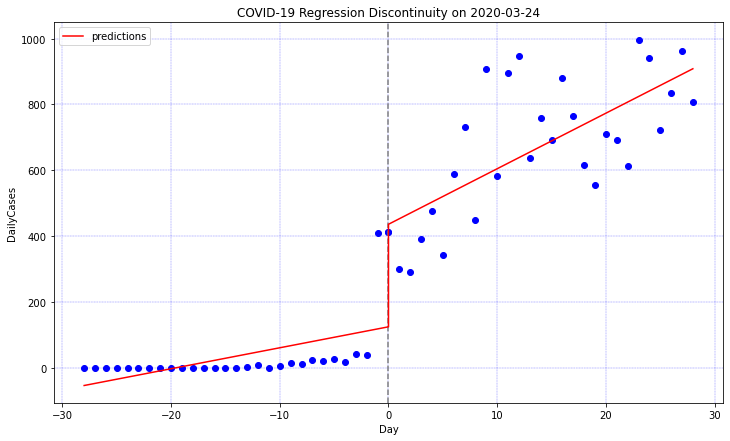

In [8]:
sub = subset_rdd(df, '2020-03-20', drange=28, lag=4)
est = plot_rdd(sub, 'DailyCases', deg1=1, deg2=1)

In [9]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             DailyCases   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     135.6
Date:                Mon, 25 Jan 2021   Prob (F-statistic):           4.04e-25
Time:                        23:47:18   Log-Likelihood:                -361.06
No. Observations:                  58   AIC:                             730.1
Df Residuals:                      54   BIC:                             738.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        124.9655     45.872      2.724      0.009      32.998     216.934
x              6.3645      2.813      2.263      0.028       0.726      12.003
const_c      311.3034     64.873      4.799      0.000     181.241     441.366
x_c           10.4980      3.978      2.639      0.011       2.523      18.473
==============================================================================
Omnibus:                       11.167   Durbin-Watson:                   1.531
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.143
Skew:                           1.000   Prob(JB):                      0.00380
Kurtosis:                       3.783   Cond. No.                         83.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpretation of the p-value for const_x (cutoff parameter)

Even though the coef is statistically significant, the gap is mostly explain by the non reported cases in the first part of the graph.

### Time included on both sides of the cutoff

I've included 4 weeks before and after the cutoff date to include the first reported case in the province (27/02/2020) and try not to capture the effect of reopening measures taken in may.

### The polynomial degree

I've used a simple linear model (before and after the cutoff) because the polynomial parameters weren't adding much to the model (not sigificant).

# The reopening of schools on 31/8/2020

At the end of the summer, the number of new daily cases was almost stable (the p-value of x is > 0.05). After the reopening of schools, we notice a sharp increase in new cases. 

The change in the shape of the curve indicates the reopening of school as played an important in kickstarting the second wave. It would be interesting to identify which segment of the population were tested positive to pinpoint if university/cegep, highschool or primary shools were mostly contributing to the spread. 

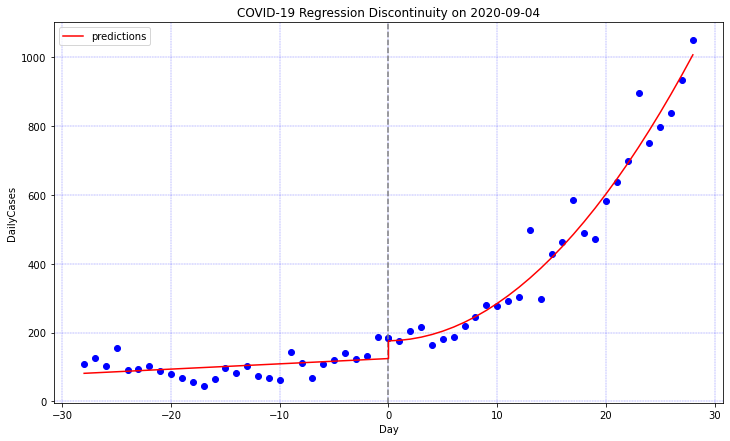

In [10]:
sub = subset_rdd(df, '2020-08-31', drange=28, lag=4)
est = plot_rdd(sub, 'DailyCases', deg1=1,  deg2=2)

In [11]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             DailyCases   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     422.5
Date:                Mon, 25 Jan 2021   Prob (F-statistic):           1.68e-39
Time:                        23:47:19   Log-Likelihood:                -303.27
No. Observations:                  58   AIC:                             616.5
Df Residuals:                      53   BIC:                             626.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        124.3724     17.094      7.276      0.000      90.086     158.659
x              1.5340      1.048      1.464      0.149      -0.568       3.636
const_c       51.4834     29.949      1.719      0.091      -8.588     111.554
x_c           -1.1033      4.199     -0.263      0.794      -9.525       7.319
x2_c           1.0455      0.140      7.452      0.000       0.764       1.327
==============================================================================
Omnibus:                       19.591   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.688
Skew:                           1.180   Prob(JB):                     3.58e-07
Kurtosis:                       5.592   Cond. No.                     1.31e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Interpretation of the p-value for const_x (cutoff parameter)

The coef is not statistically significant, meaning that the gap is neglectable. As single quadratic model could have been used for the whole graph.

### Time included on both sides of the cutoff

I've included 4 weeks before and after the cutoff to get a proper sample of data before schools reopeing and try not to capture the effect of stricter rules for schools (october 8).

### The polynomial degree

I've used a simple linear model before the cutoff because the number of new cases were almost stable and a quadratic model after to better capture the slope.

# The 25/12/2020 lockdown

There's a clear change in the sign of the slope before and after the cutoff date but the gap indicate that the number of cases continued to increase after the lockdown was in effect. I suppose people did not respect the rules until after New year's eve. This is why I repeated the exercise with January 1 as the cutoff date. 

Then we clearly see the gap is not significant and the cases immedialty start to drop, confirming the hypothesis.

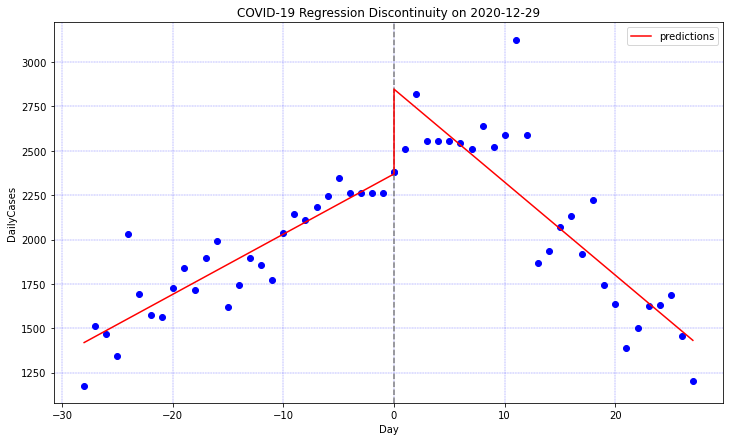

In [12]:
sub = subset_rdd(df, '2020-12-25', lag=4)
est = plot_rdd(sub, 'DailyCases', deg1=1,  deg2=1)

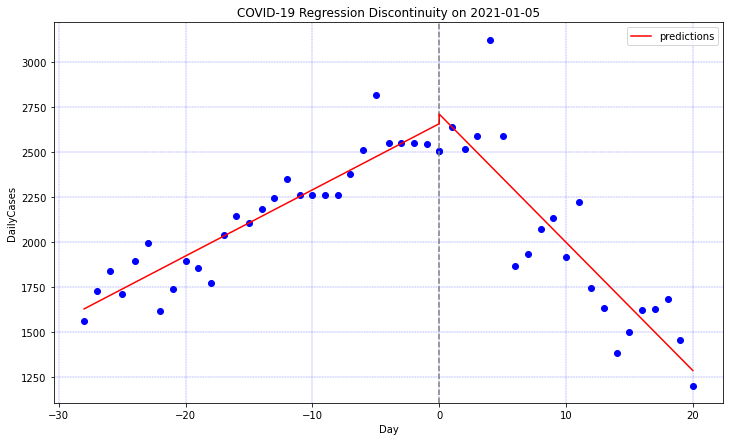

In [13]:
sub = subset_rdd(df, '2021-01-01', lag=4)
est = plot_rdd(sub, 'DailyCases', deg1=1,  deg2=1)

In [14]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             DailyCases   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     65.22
Date:                Mon, 25 Jan 2021   Prob (F-statistic):           1.34e-16
Time:                        23:47:21   Log-Likelihood:                -330.70
No. Observations:                  50   AIC:                             669.4
Df Residuals:                      46   BIC:                             677.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2659.0828     68.072     39.063      0.000    2522.061    2796.105
x             36.7842      4.174      8.813      0.000      28.383      45.186
const_c       53.4714    104.453      0.512      0.611    -156.781     263.724
x_c         -108.1063      7.959    -13.583      0.000    -124.127     -92.086
==============================================================================
Omnibus:                       16.450   Durbin-Watson:                   1.375
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.819
Skew:                           0.945   Prob(JB):                     5.52e-07
Kurtosis:                       6.203   Cond. No.                         66.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpretation of the p-value for const_x (cutoff parameter)

The coef is not statistically significant, meaning that the gap is neglectable (also confirmed graphicly).

### Time included on both sides of the cutoff

I've included 4 weeks before to get a good idea of the trend en december and used as much data as available after the cutoff.

### The polynomial degree

I've used a linear model before and after the cutoff because this simple model was sufficent to explain the trend without adding to much complexity.

## The goal of the 25/12/2020 lockdown was to prevent the reach of full capacity in hospitals. Did it work?

Using hospitalisation data we find that there's a sharp drop in hospitalisation after January 1st. But the data is realy scattered and the correlation is quite poor (R-squared < 0.30). I've decided not to pursue this analysis.

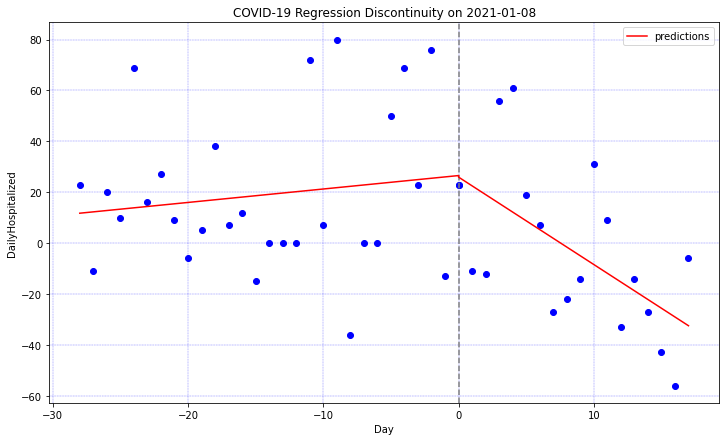

In [15]:
sub = subset_rdd(df, '2021-01-01', drange=28, lag=7)
sub = plot_rdd(sub, 'DailyHospitalized', deg1=1, deg2=1)

In [16]:
sub.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      DailyHospitalized   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     4.658
Date:                Mon, 25 Jan 2021   Prob (F-statistic):            0.00661
Time:                        23:47:23   Log-Likelihood:                -223.10
No. Observations:                  47   AIC:                             454.2
Df Residuals:                      43   BIC:                             461.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.5379     10.551      2.515      0.016       5.260      47.816
x              0.5286      0.647      0.817      0.418      -0.776       1.833
const_c       -0.5964     16.888     -0.035      0.972     -34.655      33.462
x_c           -3.9661      1.474     -2.691      0.010      -6.938      -0.994
==============================================================================
Omnibus:                        2.668   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.263   Jarque-Bera (JB):                2.515
Skew:                           0.507   Prob(JB):                        0.284
Kurtosis:                       2.494   Cond. No.                         62.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Mandatory masks indoors on 27/7/2020

Introduced on 18/7/2020 applied on 27/7/2020

Another interesting question is whether or not the masks helped reduce the spread? The answer is yes. The cutoff gap (const_c coef) indicates a drop of 41 cases per days (droping from 170 to 130 per day) when the mesure was applied. We also notice a reversal of the slope.

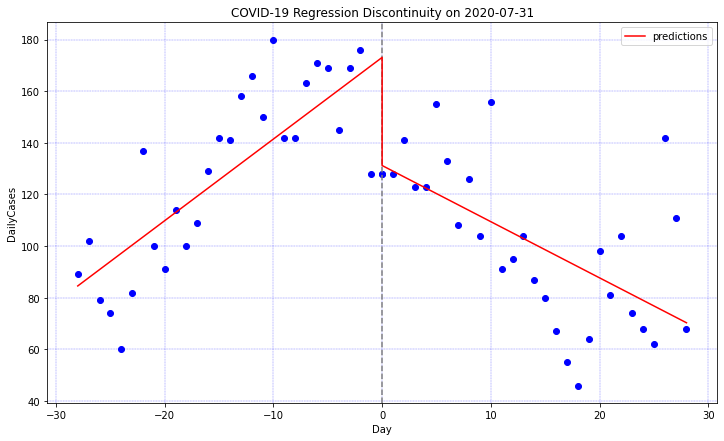

In [17]:
sub = subset_rdd(df, '2020-7-27',  drange=28, lag=4)
sub = plot_rdd(sub, 'DailyCases', deg1=1, deg2=1)

In [18]:
sub.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             DailyCases   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     24.81
Date:                Mon, 25 Jan 2021   Prob (F-statistic):           3.17e-10
Time:                        23:47:24   Log-Likelihood:                -263.48
No. Observations:                  58   AIC:                             535.0
Df Residuals:                      54   BIC:                             543.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        173.0897      8.529     20.294      0.000     155.990     190.189
x              3.1616      0.523      6.046      0.000       2.113       4.210
const_c      -41.8759     12.062     -3.472      0.001     -66.058     -17.693
x_c           -5.3369      0.740     -7.216      0.000      -6.820      -3.854
==============================================================================
Omnibus:                        2.090   Durbin-Watson:                   1.319
Prob(Omnibus):                  0.352   Jarque-Bera (JB):                1.307
Skew:                           0.314   Prob(JB):                        0.520
Kurtosis:                       3.381   Cond. No.                         83.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""